Loaded data sample:
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa


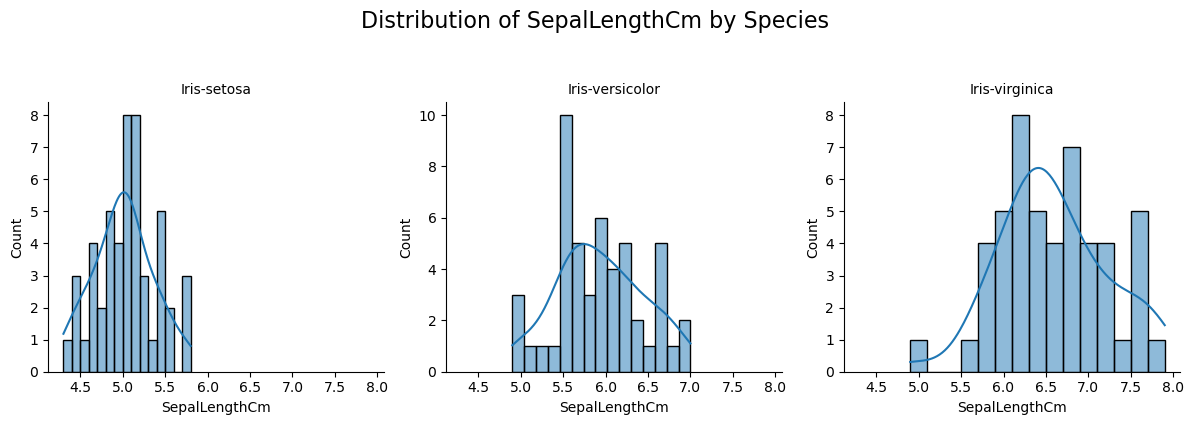

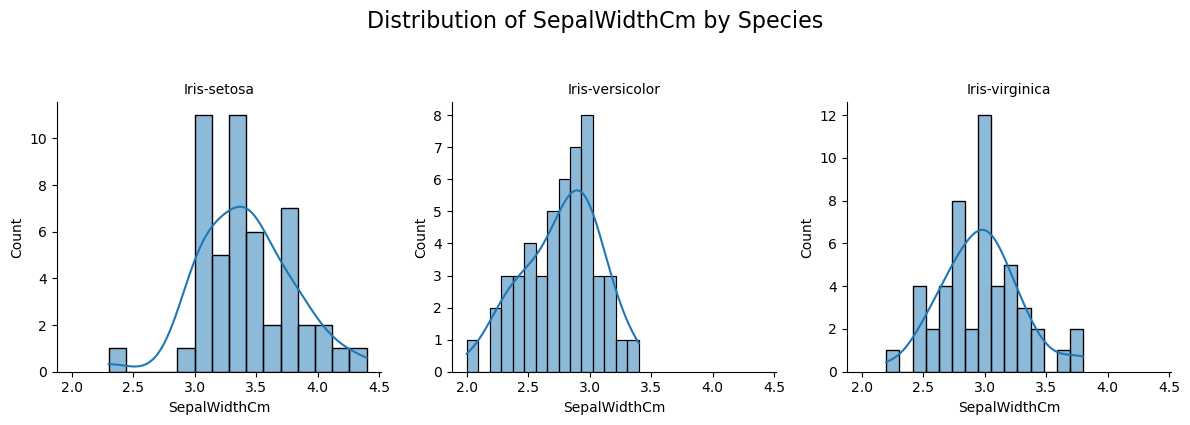

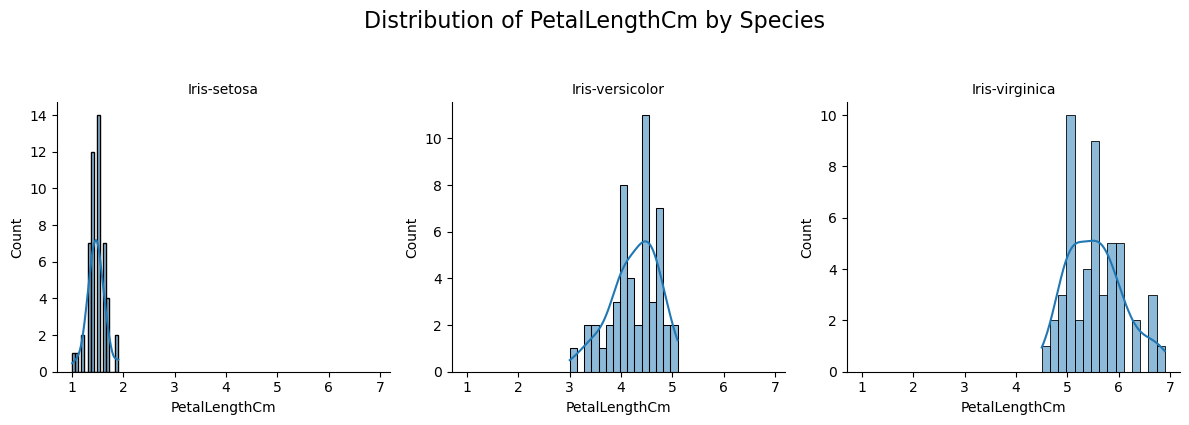

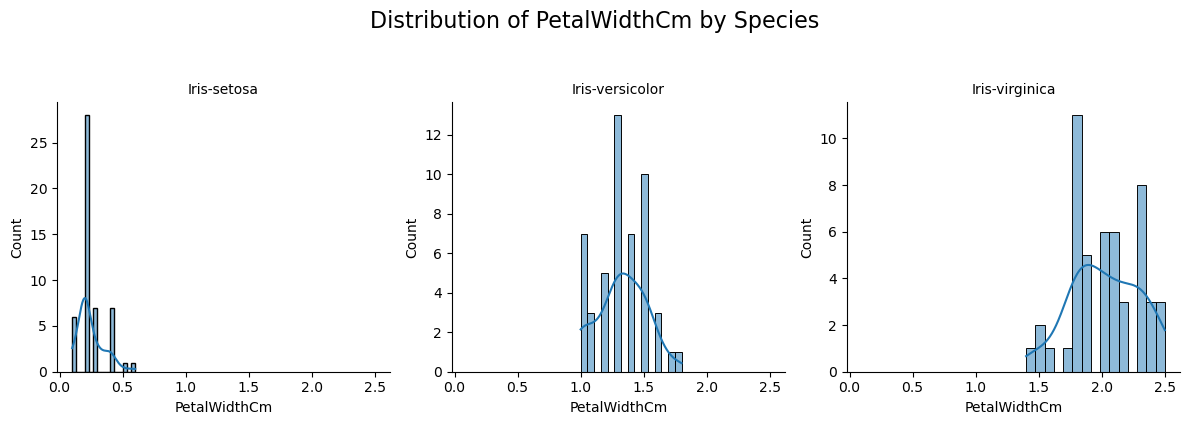

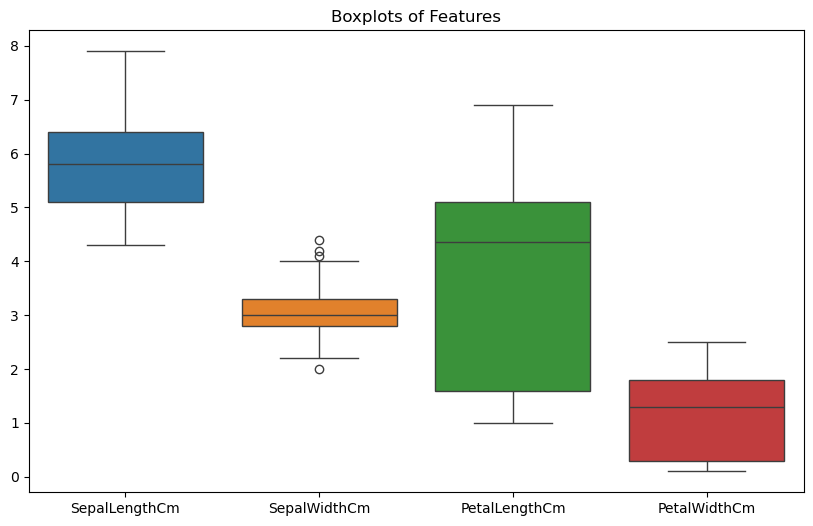

Data shape after outlier removal: (146, 5)
Class distribution:
Species
Iris-virginica     50
Iris-versicolor    49
Iris-setosa        47
Name: count, dtype: int64


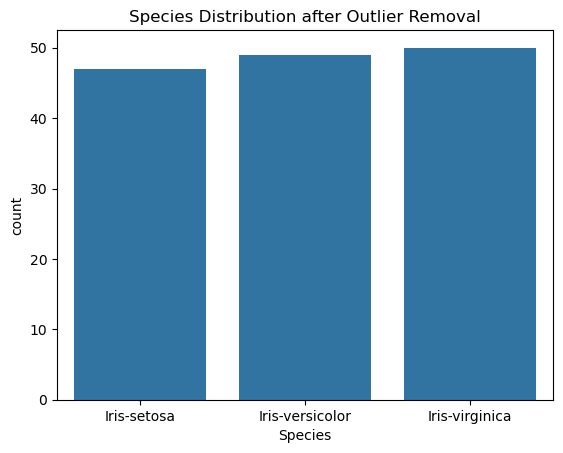

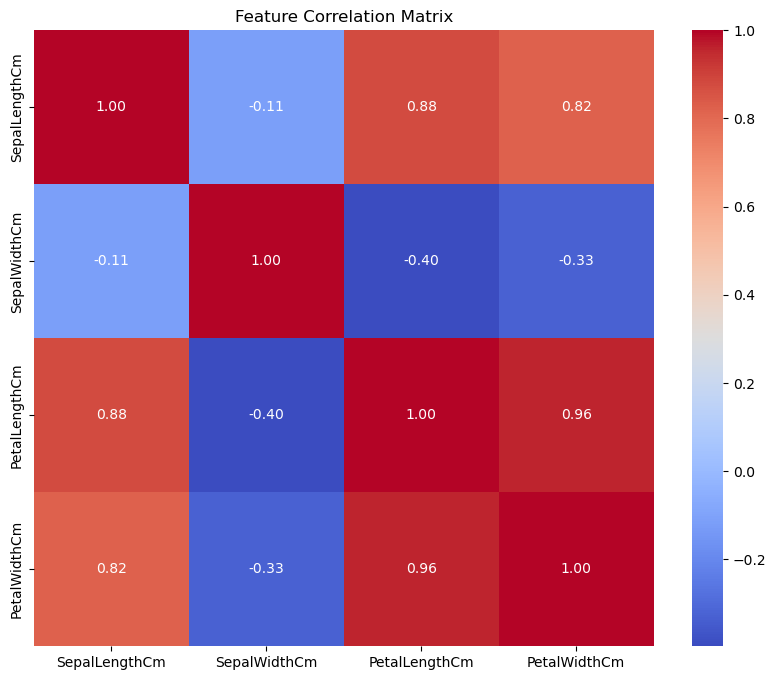

Best hyperparameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


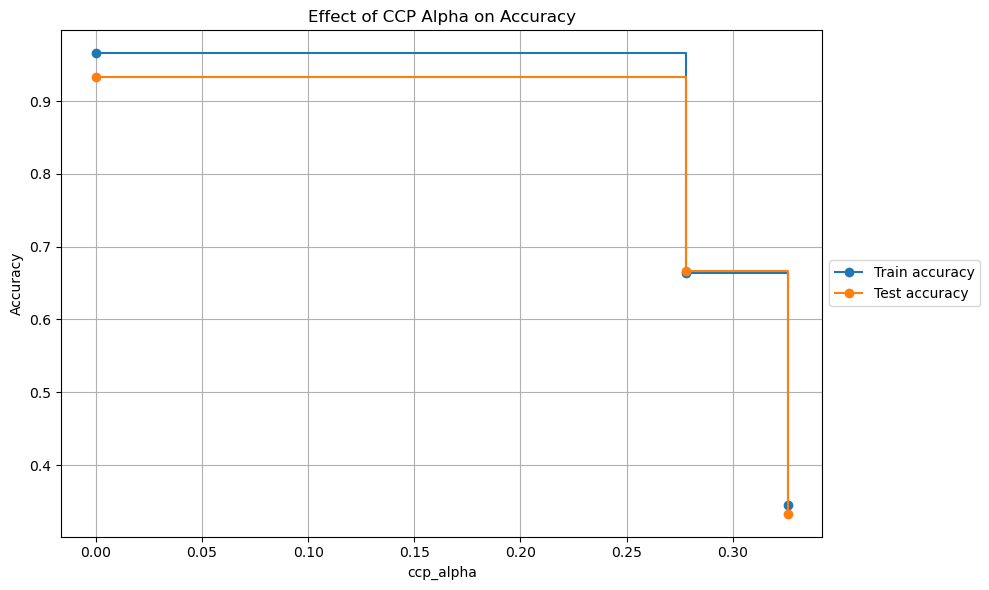

Optimal ccp_alpha: 0.0
Test Accuracy: 0.9333333333333333
Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



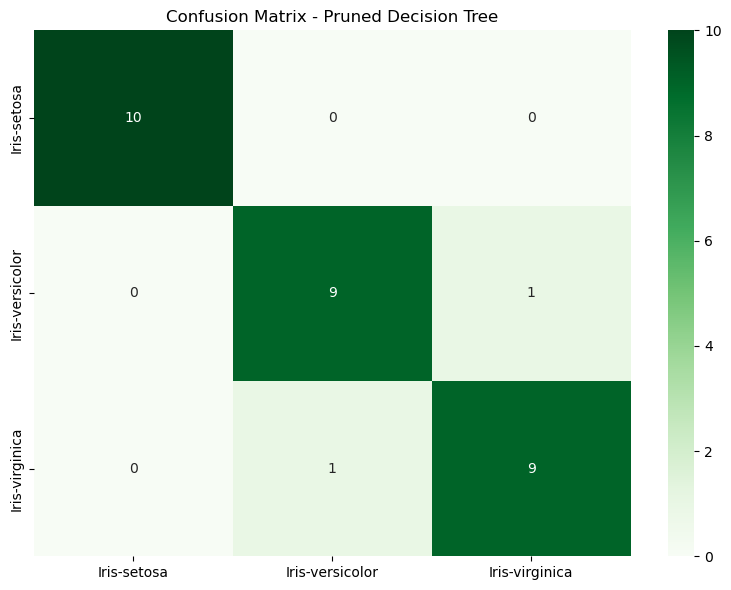

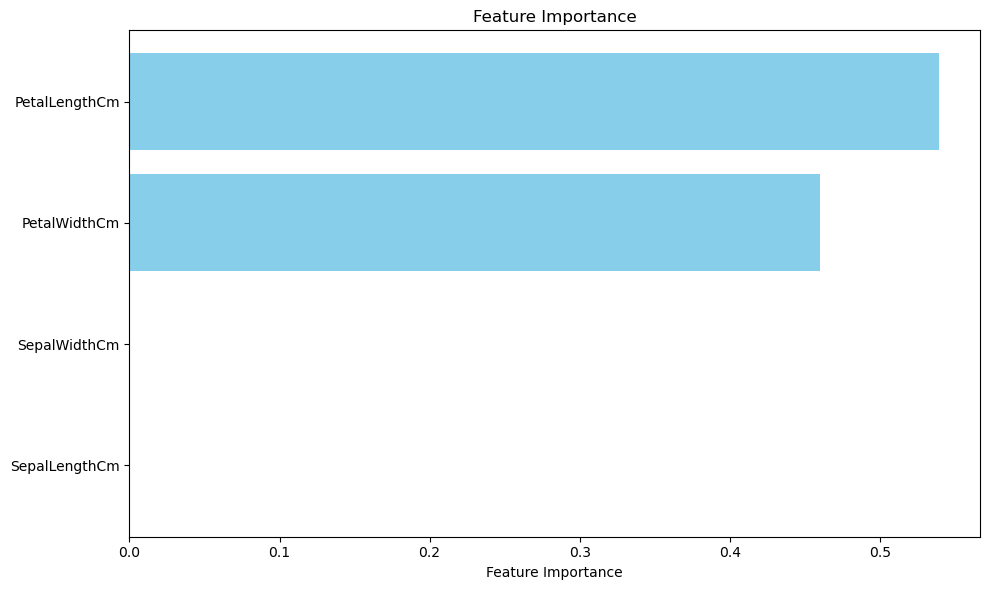

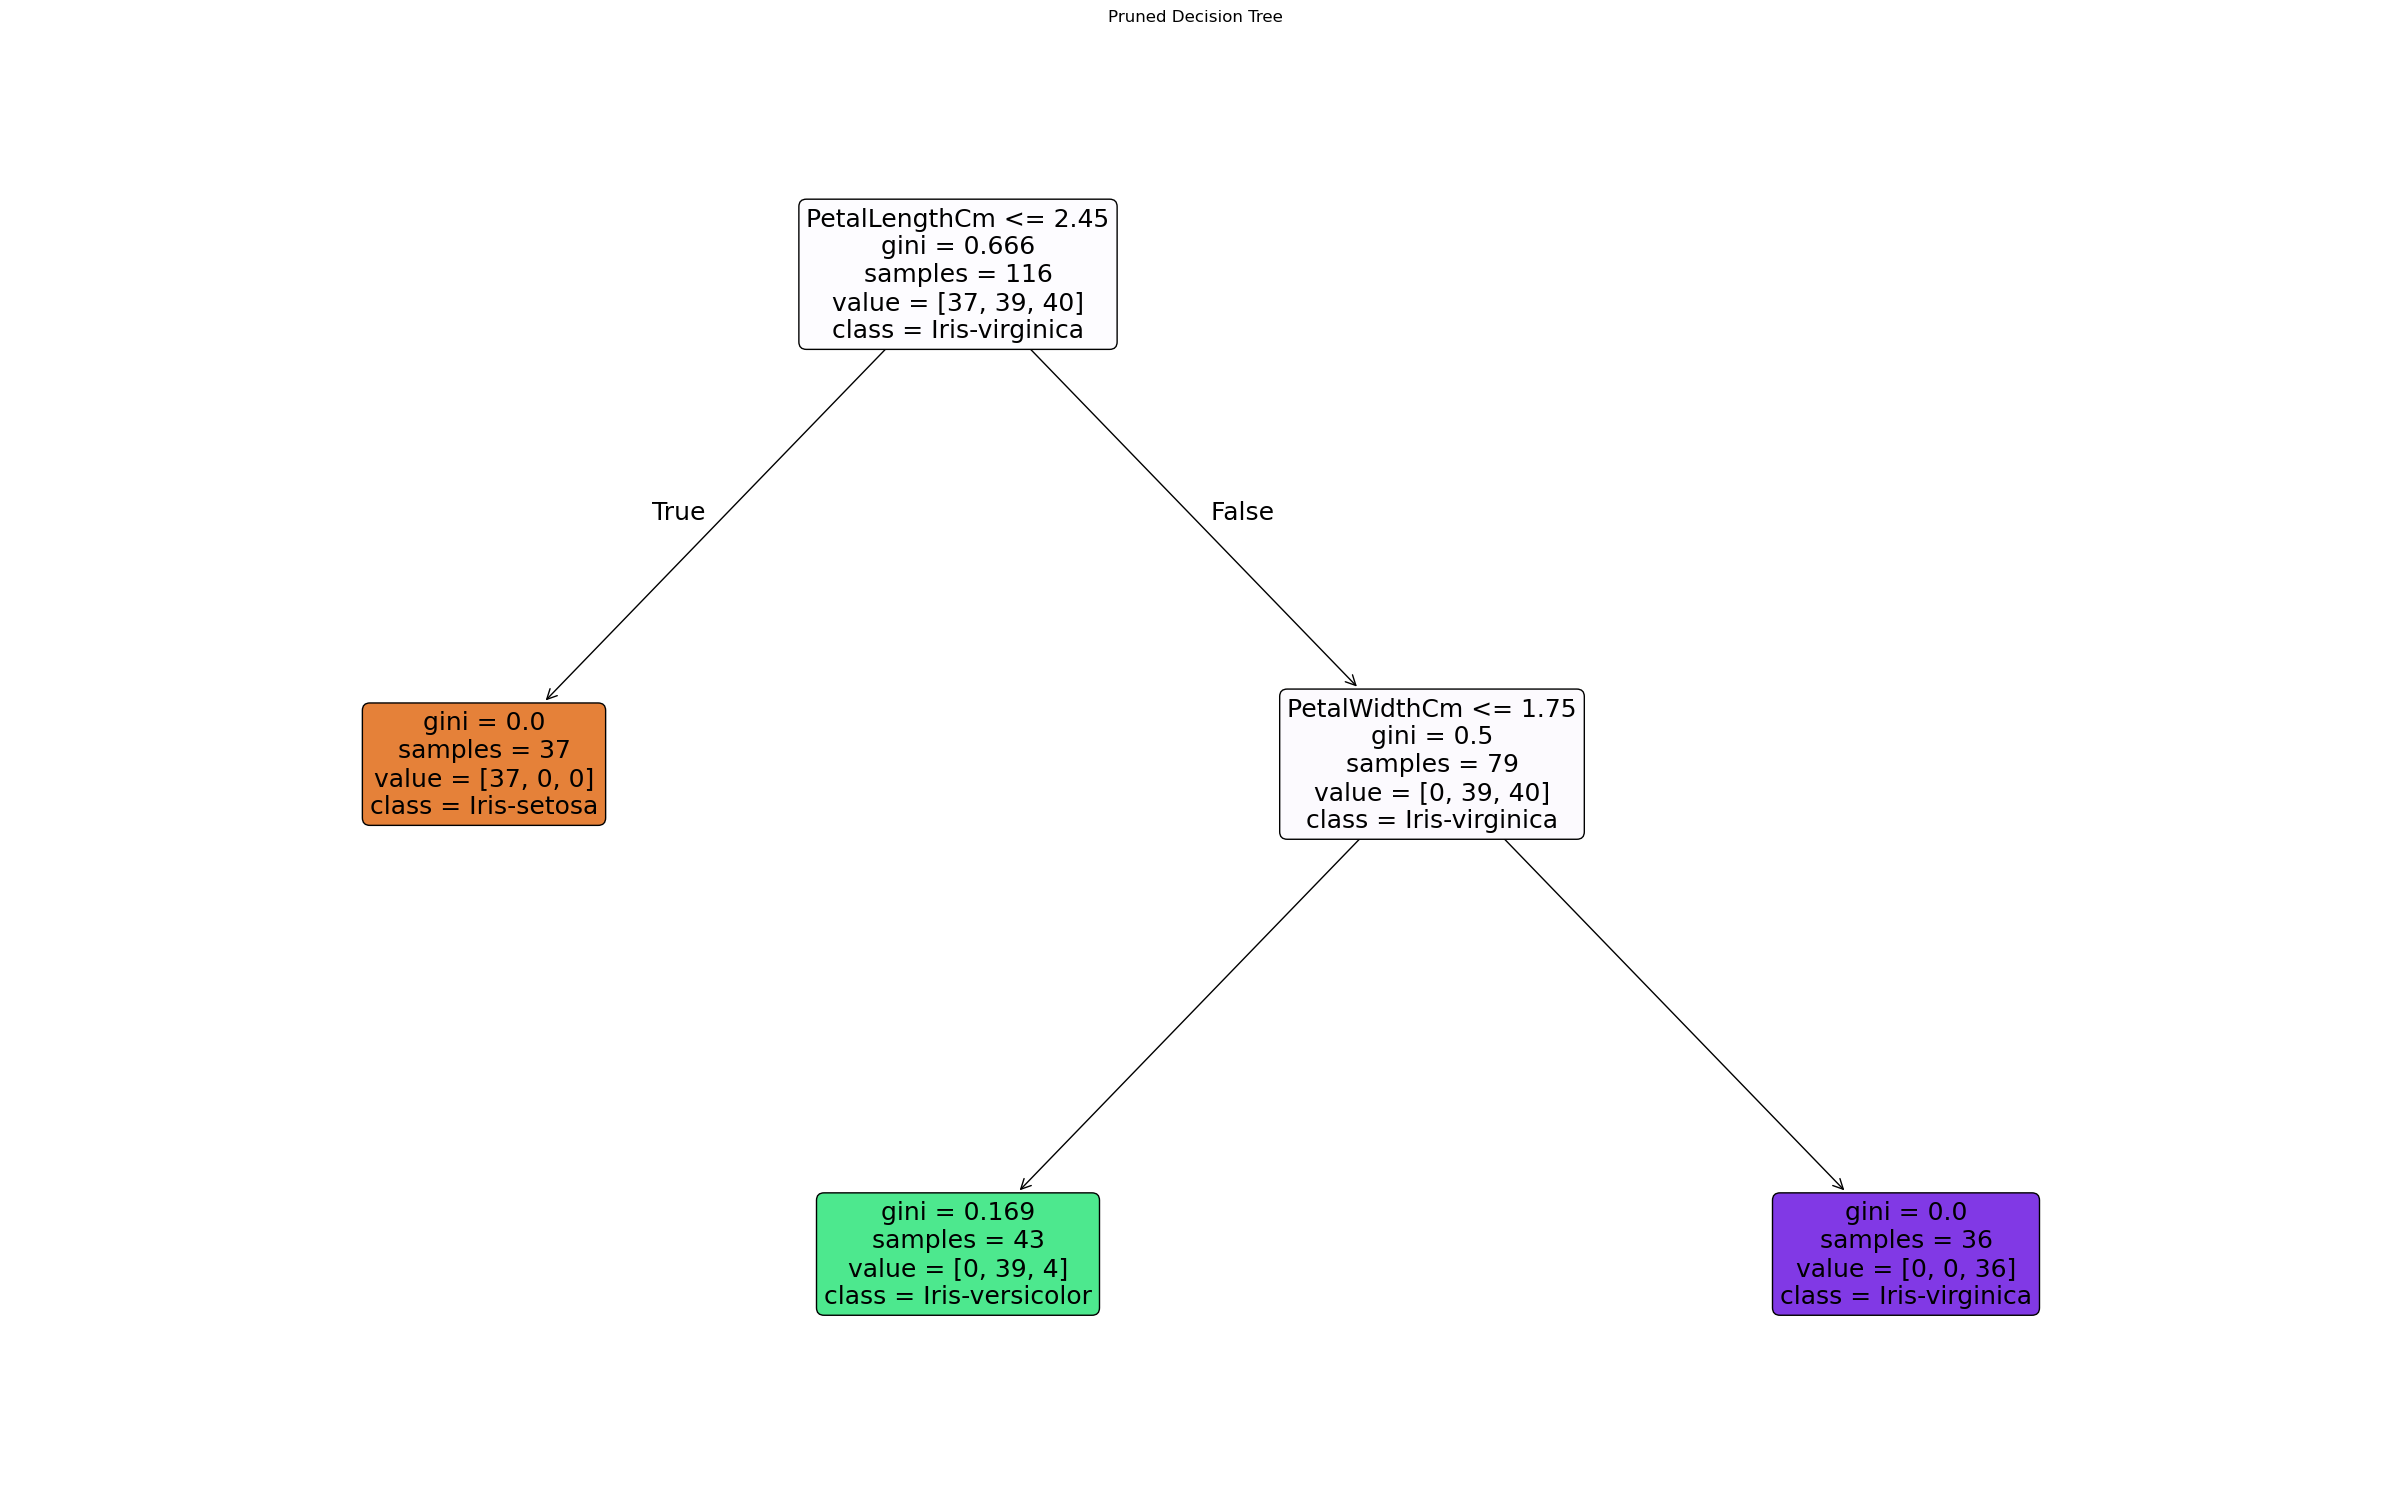

Decision Rules:
|--- PetalLengthCm <= 2.45
|   |--- class: Iris-setosa
|--- PetalLengthCm >  2.45
|   |--- PetalWidthCm <= 1.75
|   |   |--- class: Iris-versicolor
|   |--- PetalWidthCm >  1.75
|   |   |--- class: Iris-virginica



C:\Users\Maryam\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


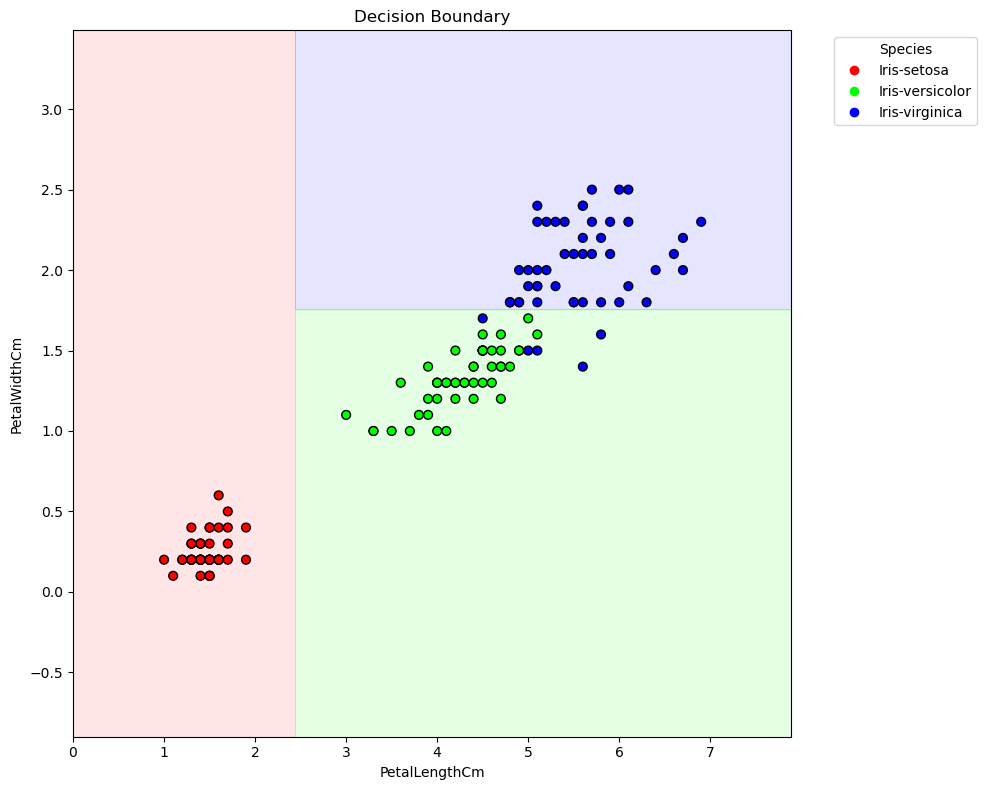

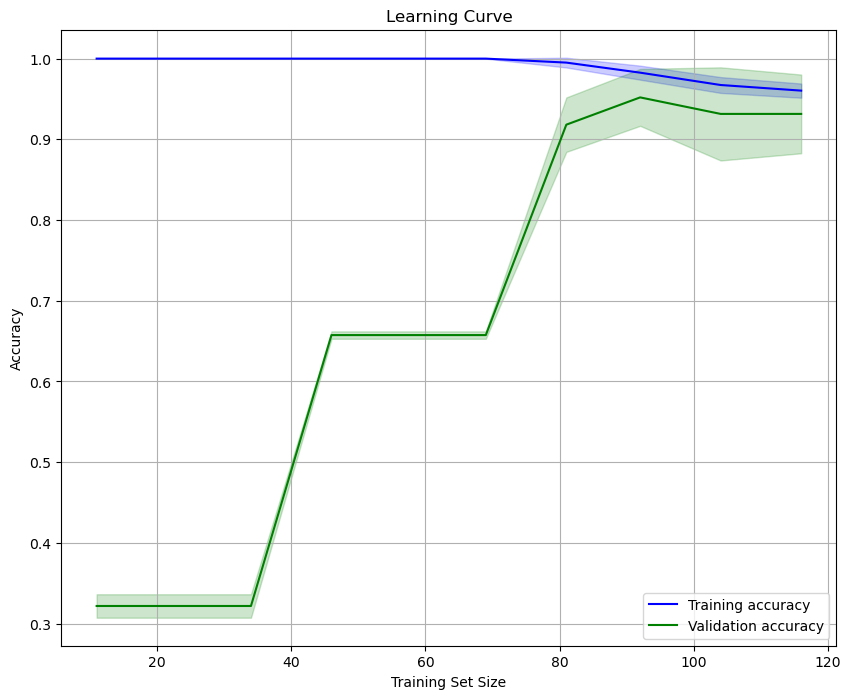

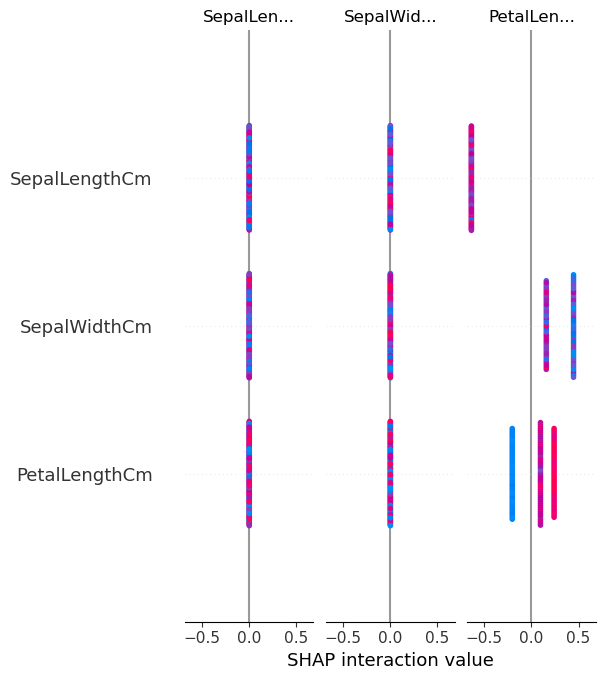

Model saved to: C:\Users\Maryam\Iris Project\outputs\pruned_decision_tree_model.joblib


In [11]:
# ------------------- Imports -------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib
import os
from matplotlib.colors import ListedColormap
import shap

# ------------------- Safe paths -------------------
base_dir = r"C:\Users\Maryam\Iris Project"  # Folder containing Iris.csv
output_dir = os.path.join(base_dir, 'outputs')
os.makedirs(output_dir, exist_ok=True)

def save_fig(filename):
    plt.savefig(os.path.join(output_dir, filename))

# ------------------- Load Dataset -------------------
base_path = os.path.join(base_dir, 'Iris.csv')
if not os.path.exists(base_path):
    raise FileNotFoundError(f"No CSV file found at {base_path}")

df = pd.read_csv(base_path)
if 'Id' in df.columns:
    df.drop('Id', axis=1, inplace=True)
print("Loaded data sample:")
print(df.head())

features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

# ------------------- EDA -------------------
for feature in features:
    g = sns.FacetGrid(df, col='Species', col_wrap=3, height=4, sharex=True, sharey=False)
    g.map(sns.histplot, feature, bins=15, kde=True)
    g.set_titles(col_template="{col_name}")
    g.fig.suptitle(f'Distribution of {feature} by Species', y=1.05, fontsize=16)
    plt.tight_layout()
    save_fig(f'distribution_{feature}_facet.png')
    plt.show()
    plt.close()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[features])
plt.title('Boxplots of Features')
save_fig('boxplot_features.png')
plt.show()
plt.close()

# ------------------- Outlier removal -------------------
Q1 = df[features].quantile(0.25)
Q3 = df[features].quantile(0.75)
IQR = Q3 - Q1
condition = ~((df[features] < (Q1 - 1.5*IQR)) | (df[features] > (Q3 + 1.5*IQR))).any(axis=1)
df_clean = df[condition].reset_index(drop=True)
print(f"Data shape after outlier removal: {df_clean.shape}")
print("Class distribution:")
print(df_clean['Species'].value_counts())

sns.countplot(x='Species', data=df_clean)
plt.title("Species Distribution after Outlier Removal")
save_fig('species_distribution.png')
plt.show()
plt.close()

plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
save_fig('feature_correlation_matrix.png')
plt.show()
plt.close()

# ------------------- Data split -------------------
X = df_clean[features]
y = df_clean['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ------------------- Hyperparameter tuning -------------------
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 11),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_dt = grid_search.best_estimator_
path = best_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, **grid_search.best_params_, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, 'o-', label='Train accuracy', drawstyle='steps-post')
plt.plot(ccp_alphas, test_scores, 'o-', label='Test accuracy', drawstyle='steps-post')
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('Effect of CCP Alpha on Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
save_fig('ccp_alpha_accuracy.png')
plt.show()
plt.close()

optimal_alpha = ccp_alphas[np.argmax(test_scores)]
print("Optimal ccp_alpha:", optimal_alpha)

pruned_dt = DecisionTreeClassifier(random_state=42, **grid_search.best_params_, ccp_alpha=optimal_alpha)
pruned_dt.fit(X_train, y_train)

# ------------------- Evaluate pruned model -------------------
y_pred = pruned_dt.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=pruned_dt.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=pruned_dt.classes_, yticklabels=pruned_dt.classes_)
plt.title('Confusion Matrix - Pruned Decision Tree')
plt.tight_layout()
save_fig("pruned_confusion_matrix.png")
plt.show()
plt.close()

# ------------------- Feature importance -------------------
importances = pruned_dt.feature_importances_
sorted_idx = importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_idx], color='skyblue')
plt.yticks(range(len(importances)), np.array(features)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.tight_layout()
save_fig('feature_importance.png')
plt.show()
plt.close()

# ------------------- Decision Tree plot -------------------
plt.figure(figsize=(24, 16))
plot_tree(pruned_dt, feature_names=features, class_names=pruned_dt.classes_, filled=True, rounded=True, fontsize=18)
plt.title('Pruned Decision Tree')
plt.tight_layout(rect=[0, 0, 1, 0.95])
save_fig('pruned_decision_tree.png')
plt.show()
plt.close()

print("Decision Rules:")
print(export_text(pruned_dt, feature_names=features))

# ------------------- Decision boundary -------------------
def plot_decision_boundary(clf, X, y, fts, title):
    idx1, idx2 = X.columns.get_loc(fts[0]), X.columns.get_loc(fts[1])
    x_min, x_max = X.iloc[:, idx1].min() - 1, X.iloc[:, idx1].max() + 1
    y_min, y_max = X.iloc[:, idx2].min() - 1, X.iloc[:, idx2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    n_points = xx.size
    X_grid = np.tile(X.mean(), (n_points, 1))
    X_grid[:, idx1] = xx.ravel()
    X_grid[:, idx2] = yy.ravel()
    Z = clf.predict(X_grid)
    class_map = {c: i for i, c in enumerate(clf.classes_)}
    Z_mapped = np.array([class_map[z] for z in Z]).reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z_mapped, alpha=0.3, cmap=ListedColormap(['#FFAAAA','#AAFFAA','#AAAAFF']))
    scatter = plt.scatter(X.iloc[:, idx1], X.iloc[:, idx2], c=[class_map[l] for l in y],
                          cmap=ListedColormap(['#FF0000','#00FF00','#0000FF']), edgecolor='k', s=40)
    handles, _ = scatter.legend_elements()
    plt.legend(handles=handles, labels=list(clf.classes_), title="Species", bbox_to_anchor=(1.05,1), loc='upper left')
    plt.xlabel(fts[0])
    plt.ylabel(fts[1])
    plt.title(title)
    plt.tight_layout()
    save_fig('decision_boundary.png')
    plt.show()
    plt.close()

plot_decision_boundary(pruned_dt, X, y, ['PetalLengthCm','PetalWidthCm'], 'Decision Boundary')

# ------------------- Learning curve -------------------
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv,
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           scoring='accuracy', n_jobs=-1)
    plt.figure(figsize=(10,8))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy', color='blue')
    plt.fill_between(train_sizes, train_scores.mean(axis=1)-train_scores.std(axis=1),
                     train_scores.mean(axis=1)+train_scores.std(axis=1), alpha=0.2, color='blue')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy', color='green')
    plt.fill_between(train_sizes, test_scores.mean(axis=1)-test_scores.std(axis=1),
                     test_scores.mean(axis=1)+test_scores.std(axis=1), alpha=0.2, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    save_fig('learning_curve.png')
    plt.show()
    plt.close()

plot_learning_curve(pruned_dt, X, y)

# ------------------- SHAP explainability -------------------
explainer = shap.TreeExplainer(pruned_dt)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=features)

# ------------------- Save the model -------------------
model_file = os.path.join(output_dir, 'pruned_decision_tree_model.joblib')
joblib.dump(pruned_dt, model_file)
print(f'Model saved to: {model_file}')
